# Membership Inference Attack - LiRA (Likelihood Ratio Attack)

This notebook implements **proper Gaussian Likelihood Ratio LiRA** with 32 shadow models.

## Proper LiRA Algorithm

**Key Insight:** Compare target model's loss to IN vs OUT loss distributions using likelihood ratio.

**Per-Example Setup:**
- **32 shadow models**: Each test sample has 16 IN shadows and 16 OUT shadows
- **Membership matrix M[j, s]**: Tracks which shadows trained on which samples  
- **Per-sample calibration**: Each sample has its own IN/OUT distributions

**Gaussian Likelihood Ratio:**
```python
For each test sample j:
  # Get IN/OUT shadows for this sample (from keep_matrix)
  IN_shadows = [s where M[j, s] == 1]   # 16 shadows
  OUT_shadows = [s where M[j, s] == 0]  # 16 shadows
  
  # Extract losses from these specific shadows
  IN_losses = [loss from shadow s for s in IN_shadows]   # 16 values
  OUT_losses = [loss from shadow s for s in OUT_shadows] # 16 values
  
  # Fit Gaussian distributions
  IN_dist = N(μ_in, σ_in²)   # Gaussian fit to IN_losses
  OUT_dist = N(μ_out, σ_out²) # Gaussian fit to OUT_losses
  
  # Get target's loss on this sample
  target_loss = target_model.loss(sample_j)
  
  # Compute log-likelihood ratio
  LLR = log P(target_loss | OUT_dist) - log P(target_loss | IN_dist)
  
  # For Gaussian:
  log P(x | N(μ, σ²)) = -log(σ) - 0.5 * ((x - μ) / σ)²
  
  # Score (negate so higher = member)
  score[j] = -LLR = log P(target_loss | IN) - log P(target_loss | OUT)
```

- **Members**: Target saw sample → low loss → more likely under IN distribution → high score
- **Non-members**: Target didn't see → higher loss → more likely under OUT distribution → low score



In [40]:
# Cell 1: Imports
import torch
import numpy as np
import json
from pathlib import Path
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorForLanguageModeling
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti


In [41]:
# Cell 2: Configuration

# Target model (for evaluation only)
phase = "train"  # Change to "val" or "final" for submission
target_model_dir = f"./models/{phase}/gpt2_3_lora32_adamw_b8_lr2"
target_data_dir = Path(f"./data/{phase}/")

# LiRA shadow models
SHADOW_DATA_DIR = "./data/shadow_datasets_lira"
SHADOW_MODEL_DIR = "./models/shadow_lira"
NUM_SHADOW_MODELS = 32  # Per-example LiRA with 32 shadows (16 IN, 16 OUT per sample)

# Model settings
batch_size = 8
block_size = 512

print("="*70)
print("PER-EXAMPLE LiRA CONFIGURATION (32 SHADOWS)")
print("="*70)
print(f"Phase: {phase}")
print(f"Target model: {target_model_dir}")
print(f"\nShadow models: {NUM_SHADOW_MODELS}")
print(f"  Directory: {SHADOW_MODEL_DIR}/")
print(f"  Per-sample: 16 IN, 16 OUT (randomly assigned)")
print(f"\nData: {SHADOW_DATA_DIR}/")
print(f"Batch size: {batch_size}")
print("\nMethod: Per-example LiRA with membership matrix")
print("="*70)

PER-EXAMPLE LiRA CONFIGURATION (32 SHADOWS)
Phase: train
Target model: ./models/train/gpt2_3_lora32_adamw_b8_lr2

Shadow models: 32
  Directory: ./models/shadow_lira/
  Per-sample: 16 IN, 16 OUT (randomly assigned)

Data: ./data/shadow_datasets_lira/
Batch size: 8

Method: Per-example LiRA with membership matrix


In [42]:
# Cell 3: Helper Functions

def _read_json(path):
    with open(path, 'r') as f:
        return json.load(f)

def tokenize_dataset(dataset, tokenizer, block_size):
    def tokenize_fn(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            max_length=block_size,
            padding='max_length',
            return_tensors=None
        )
    
    tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=dataset.column_names)
    
    def add_labels(examples):
        examples['labels'] = examples['input_ids'].copy()
        return examples
    
    return tokenized.map(add_labels, batched=True)

def cleanup_gpu():
    gc.collect()
    torch.cuda.empty_cache()

print("✓ Helper functions defined")

✓ Helper functions defined


In [43]:
# Cell 4: Loss Extraction Function

@torch.no_grad()
def extract_avg_loss(model, dataloader, device):
    """
    Extract per-sample average loss
    
    Returns:
        avg_loss: numpy array of shape (num_samples,)
    """
    model.eval()
    all_losses = []
    
    for batch in tqdm(dataloader, desc="Extracting losses"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = input_ids.clone()
        
        # Forward
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        
        # Shift for causal LM
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_mask = attention_mask[..., 1:].contiguous()
        
        # Per-token loss
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        per_token_loss = loss_fct(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        ).view(shift_labels.size())
        
        # Mask padding
        per_token_loss = per_token_loss * shift_mask
        
        # Per-sample average
        for i in range(input_ids.size(0)):
            mask_i = shift_mask[i].bool()
            valid_losses = per_token_loss[i][mask_i]
            avg_loss = valid_losses.mean().item() if len(valid_losses) > 0 else 0.0
            all_losses.append(avg_loss)
        
        # Cleanup
        del logits, outputs, per_token_loss
        torch.cuda.empty_cache()
    
    return np.array(all_losses)

print("✓ Loss extraction function defined")

✓ Loss extraction function defined


In [44]:
# Cell 5: Load Test Data and Membership Matrix

print("="*70)
print("LOADING DATA")
print("="*70)

# Load test set
test_file = Path(SHADOW_DATA_DIR) / "test.json"
test_texts = _read_json(test_file)
print(f"✓ Test data: {len(test_texts)} samples")

# Load membership matrix M
keep_matrix_file = Path(SHADOW_DATA_DIR) / "keep_matrix.npy"
keep_matrix = np.load(keep_matrix_file)
print(f"✓ Membership matrix M: {keep_matrix.shape}")

# Verify
if keep_matrix.shape[0] != len(test_texts):
    raise ValueError(f"Matrix rows {keep_matrix.shape[0]} != samples {len(test_texts)}")
if keep_matrix.shape[1] < NUM_SHADOW_MODELS:
    raise ValueError(f"Matrix has {keep_matrix.shape[1]} shadows < {NUM_SHADOW_MODELS}")

# Use only first NUM_SHADOW_MODELS
keep_matrix = keep_matrix[:, :NUM_SHADOW_MODELS]
print(f"  Using {NUM_SHADOW_MODELS} shadows")

# Statistics
print(f"\nPer-shadow IN counts:")
for s in range(NUM_SHADOW_MODELS):
    in_count = keep_matrix[:, s].sum()
    print(f"  Shadow {s}: {in_count}/{len(test_texts)} ({in_count/len(test_texts):.1%})")

in_counts = keep_matrix.sum(axis=1)
print(f"\nPer-sample IN counts:")
print(f"  Min: {in_counts.min()}, Max: {in_counts.max()}, Mean: {in_counts.mean():.2f}")
print(f"  Expected: 2 IN shadows per sample")

# Load labels
try:
    test_labels = np.array(_read_json(target_data_dir / "test_label.json"))
    has_labels = True
    print(f"\n✓ Labels: {len(test_labels)}")
    print(f"  Members: {test_labels.sum()}, Non-members: {len(test_labels) - test_labels.sum()}")
except:
    test_labels = None
    has_labels = False
    print(f"\n⚠️  No labels (val/final phase)")

print("="*70)

LOADING DATA
✓ Test data: 2000 samples
✓ Membership matrix M: (2000, 32)
  Using 32 shadows

Per-shadow IN counts:
  Shadow 0: 1032/2000 (51.6%)
  Shadow 1: 960/2000 (48.0%)
  Shadow 2: 1019/2000 (50.9%)
  Shadow 3: 1010/2000 (50.5%)
  Shadow 4: 1046/2000 (52.3%)
  Shadow 5: 993/2000 (49.6%)
  Shadow 6: 974/2000 (48.7%)
  Shadow 7: 993/2000 (49.6%)
  Shadow 8: 1002/2000 (50.1%)
  Shadow 9: 985/2000 (49.2%)
  Shadow 10: 1024/2000 (51.2%)
  Shadow 11: 970/2000 (48.5%)
  Shadow 12: 1026/2000 (51.3%)
  Shadow 13: 1018/2000 (50.9%)
  Shadow 14: 992/2000 (49.6%)
  Shadow 15: 1002/2000 (50.1%)
  Shadow 16: 940/2000 (47.0%)
  Shadow 17: 1016/2000 (50.8%)
  Shadow 18: 1022/2000 (51.1%)
  Shadow 19: 979/2000 (48.9%)
  Shadow 20: 987/2000 (49.4%)
  Shadow 21: 996/2000 (49.8%)
  Shadow 22: 977/2000 (48.9%)
  Shadow 23: 1011/2000 (50.5%)
  Shadow 24: 1029/2000 (51.4%)
  Shadow 25: 997/2000 (49.9%)
  Shadow 26: 1018/2000 (50.9%)
  Shadow 27: 998/2000 (49.9%)
  Shadow 28: 1014/2000 (50.7%)
  Shadow 2

In [45]:
# Cell 6: Prepare DataLoader

print("Preparing dataloader...")

tokenizer = AutoTokenizer.from_pretrained(f"{SHADOW_MODEL_DIR}/shadow_0", use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

ds_test = Dataset.from_dict({"text": test_texts})
ds_test = tokenize_dataset(ds_test, tokenizer, block_size)
ds_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
dl_test = DataLoader(ds_test, batch_size=batch_size, collate_fn=data_collator)

print(f"✓ Dataset: {len(ds_test)} samples, {len(dl_test)} batches")

Preparing dataloader...


Map: 100%|██████████| 2000/2000 [00:00<00:00, 4327.03 examples/s]

✓ Dataset: 2000 samples, 250 batches


In [46]:
# Cell 7: Extract Target Model Losses (REQUIRED FOR LiRA!)

print("="*70)
print("TARGET MODEL LOSSES (REQUIRED FOR LiRA)")
print("="*70)

if not Path(target_model_dir).exists():
    raise FileNotFoundError(f"Target model required for LiRA: {target_model_dir}")

target_model = AutoModelForCausalLM.from_pretrained(
    target_model_dir,
    torch_dtype=torch.float16,
    device_map=device
)

target_losses = extract_avg_loss(target_model, dl_test, device)
print(f"✓ Target losses: {target_losses.shape}, mean={target_losses.mean():.4f}")

del target_model
cleanup_gpu()
print("="*70)

TARGET MODEL LOSSES (REQUIRED FOR LiRA)


Extracting losses: 100%|██████████| 250/250 [00:14<00:00, 17.38it/s]


✓ Target losses: (2000,), mean=3.3377


In [47]:
# Cell 8: Extract Shadow Model Losses

print("="*70)
print(f"EXTRACTING SHADOW LOSSES ({NUM_SHADOW_MODELS} models)")
print("="*70)

shadow_losses = []

for shadow_id in range(NUM_SHADOW_MODELS):
    shadow_dir = f"{SHADOW_MODEL_DIR}/shadow_{shadow_id}"
    
    print(f"\n[{shadow_id+1}/{NUM_SHADOW_MODELS}] Shadow {shadow_id}: {shadow_dir}")
    
    if not Path(shadow_dir).exists():
        raise FileNotFoundError(f"Shadow model not found: {shadow_dir}")
    
    # Load model
    shadow_model = AutoModelForCausalLM.from_pretrained(
        shadow_dir,
        torch_dtype=torch.float16,
        device_map=device
    )
    
    # Verify keep array
    keep_file = Path(shadow_dir) / "keep.npy"
    if keep_file.exists():
        keep_arr = np.load(keep_file)
        print(f"  Keep array: {keep_arr.sum()} samples IN")
    
    # Extract losses
    losses = extract_avg_loss(shadow_model, dl_test, device)
    shadow_losses.append(losses)
    
    print(f"  ✓ Losses: {losses.shape}, mean={losses.mean():.4f}")
    
    del shadow_model
    cleanup_gpu()

# Convert to array: (num_shadows, num_samples)
shadow_losses = np.array(shadow_losses)

print(f"\n{'='*70}")
print(f"✓ Shadow losses: {shadow_losses.shape}")
print(f"  (shadows={shadow_losses.shape[0]}, samples={shadow_losses.shape[1]})")
print("="*70)

EXTRACTING SHADOW LOSSES (32 models)

[1/32] Shadow 0: ./models/shadow_lira/shadow_0
  Keep array: 988 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 14.85it/s]


  ✓ Losses: (2000,), mean=3.3348

[2/32] Shadow 1: ./models/shadow_lira/shadow_1
  Keep array: 984 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.48it/s] 


  ✓ Losses: (2000,), mean=3.3354

[3/32] Shadow 2: ./models/shadow_lira/shadow_2
  Keep array: 1010 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.29it/s]


  ✓ Losses: (2000,), mean=3.3339

[4/32] Shadow 3: ./models/shadow_lira/shadow_3
  Keep array: 1018 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.80it/s] 


  ✓ Losses: (2000,), mean=3.3343

[5/32] Shadow 4: ./models/shadow_lira/shadow_4
  Keep array: 1046 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.58it/s]


  ✓ Losses: (2000,), mean=3.3343

[6/32] Shadow 5: ./models/shadow_lira/shadow_5
  Keep array: 993 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.83it/s] 


  ✓ Losses: (2000,), mean=3.3353

[7/32] Shadow 6: ./models/shadow_lira/shadow_6
  Keep array: 974 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.31it/s]


  ✓ Losses: (2000,), mean=3.3359

[8/32] Shadow 7: ./models/shadow_lira/shadow_7
  Keep array: 993 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.84it/s] 


  ✓ Losses: (2000,), mean=3.3343

[9/32] Shadow 8: ./models/shadow_lira/shadow_8
  Keep array: 1002 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.03it/s]


  ✓ Losses: (2000,), mean=3.3349

[10/32] Shadow 9: ./models/shadow_lira/shadow_9
  Keep array: 985 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.91it/s]


  ✓ Losses: (2000,), mean=3.3341

[11/32] Shadow 10: ./models/shadow_lira/shadow_10
  Keep array: 1024 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.44it/s]


  ✓ Losses: (2000,), mean=3.3333

[12/32] Shadow 11: ./models/shadow_lira/shadow_11
  Keep array: 970 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.82it/s]


  ✓ Losses: (2000,), mean=3.3355

[13/32] Shadow 12: ./models/shadow_lira/shadow_12
  Keep array: 1026 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.38it/s]


  ✓ Losses: (2000,), mean=3.3326

[14/32] Shadow 13: ./models/shadow_lira/shadow_13
  Keep array: 1018 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.91it/s]


  ✓ Losses: (2000,), mean=3.3338

[15/32] Shadow 14: ./models/shadow_lira/shadow_14
  Keep array: 992 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.89it/s]


  ✓ Losses: (2000,), mean=3.3344

[16/32] Shadow 15: ./models/shadow_lira/shadow_15
  Keep array: 1002 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.44it/s]


  ✓ Losses: (2000,), mean=3.3331

[17/32] Shadow 16: ./models/shadow_lira/shadow_16
  Keep array: 940 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.36it/s]


  ✓ Losses: (2000,), mean=3.3371

[18/32] Shadow 17: ./models/shadow_lira/shadow_17
  Keep array: 1016 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.12it/s]


  ✓ Losses: (2000,), mean=3.3337

[19/32] Shadow 18: ./models/shadow_lira/shadow_18
  Keep array: 1022 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.91it/s] 


  ✓ Losses: (2000,), mean=3.3331

[20/32] Shadow 19: ./models/shadow_lira/shadow_19
  Keep array: 979 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.47it/s]


  ✓ Losses: (2000,), mean=3.3345

[21/32] Shadow 20: ./models/shadow_lira/shadow_20
  Keep array: 987 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.33it/s] 


  ✓ Losses: (2000,), mean=3.3342

[22/32] Shadow 21: ./models/shadow_lira/shadow_21
  Keep array: 996 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.47it/s]


  ✓ Losses: (2000,), mean=3.3353

[23/32] Shadow 22: ./models/shadow_lira/shadow_22
  Keep array: 977 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.32it/s] 


  ✓ Losses: (2000,), mean=3.3365

[24/32] Shadow 23: ./models/shadow_lira/shadow_23
  Keep array: 1011 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.02it/s]


  ✓ Losses: (2000,), mean=3.3339

[25/32] Shadow 24: ./models/shadow_lira/shadow_24
  Keep array: 1029 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.30it/s] 


  ✓ Losses: (2000,), mean=3.3333

[26/32] Shadow 25: ./models/shadow_lira/shadow_25
  Keep array: 997 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.21it/s]


  ✓ Losses: (2000,), mean=3.3335

[27/32] Shadow 26: ./models/shadow_lira/shadow_26
  Keep array: 1018 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.98it/s] 


  ✓ Losses: (2000,), mean=3.3331

[28/32] Shadow 27: ./models/shadow_lira/shadow_27
  Keep array: 998 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.39it/s]


  ✓ Losses: (2000,), mean=3.3345

[29/32] Shadow 28: ./models/shadow_lira/shadow_28
  Keep array: 1014 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 17.91it/s] 


  ✓ Losses: (2000,), mean=3.3325

[30/32] Shadow 29: ./models/shadow_lira/shadow_29
  Keep array: 964 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.22it/s]


  ✓ Losses: (2000,), mean=3.3361

[31/32] Shadow 30: ./models/shadow_lira/shadow_30
  Keep array: 1003 samples IN


Extracting losses: 100%|██████████| 250/250 [00:13<00:00, 18.82it/s]


  ✓ Losses: (2000,), mean=3.3349

[32/32] Shadow 31: ./models/shadow_lira/shadow_31
  Keep array: 1003 samples IN


Extracting losses: 100%|██████████| 250/250 [00:16<00:00, 15.23it/s]


  ✓ Losses: (2000,), mean=3.3343

✓ Shadow losses: (32, 2000)
  (shadows=32, samples=2000)


In [48]:
# Cell 9: Compute Proper Gaussian Likelihood Ratio (LiRA)

print("="*70)
print("COMPUTING GAUSSIAN LIKELIHOOD RATIO (LiRA)")
print("="*70)

def gaussian_log_likelihood(x, mean, std):
    """
    Compute log P(x | N(mean, std²))
    
    For Gaussian: log P(x) = -log(σ) - 0.5 * ((x - μ) / σ)²  (ignoring constant -0.5*log(2π))
    """
    std_safe = np.maximum(std, 1e-6)  # Avoid division by zero
    return -np.log(std_safe) - 0.5 * ((x - mean) / std_safe)**2

num_samples = len(test_texts)
lira_scores = np.zeros(num_samples)
in_means = np.zeros(num_samples)
out_means = np.zeros(num_samples)
in_stds = np.zeros(num_samples)
out_stds = np.zeros(num_samples)

# For each test sample, compute likelihood ratio
for j in tqdm(range(num_samples), desc="Computing LiRA scores"):
    # Get IN/OUT shadows for this sample
    keep_arr = keep_matrix[j, :]  # Shape: (num_shadows,)
    in_mask = (keep_arr == 1)
    out_mask = (keep_arr == 0)
    
    # Get losses from IN and OUT shadows
    in_losses = shadow_losses[in_mask, j]  # 16 losses from IN shadows
    out_losses = shadow_losses[out_mask, j]  # 16 losses from OUT shadows
    
    # Compute statistics for IN and OUT distributions
    if len(in_losses) > 0:
        in_mean = np.mean(in_losses)
        in_std = np.std(in_losses) if len(in_losses) > 1 else 0.01
    else:
        in_mean = 0.0
        in_std = 0.01
    
    if len(out_losses) > 0:
        out_mean = np.mean(out_losses)
        out_std = np.std(out_losses) if len(out_losses) > 1 else 0.01
    else:
        out_mean = 0.0
        out_std = 0.01
    
    # Store for analysis
    in_means[j] = in_mean
    out_means[j] = out_mean
    in_stds[j] = in_std
    out_stds[j] = out_std
    
    # ========== PROPER LiRA: Gaussian Likelihood Ratio ==========
    # Compare target's loss to IN vs OUT distributions
    target_loss_j = target_losses[j]
    
    # Log-likelihood under OUT distribution (non-member)
    log_p_out = gaussian_log_likelihood(target_loss_j, out_mean, out_std)
    
    # Log-likelihood under IN distribution (member)
    log_p_in = gaussian_log_likelihood(target_loss_j, in_mean, in_std)
    
    # Likelihood ratio: positive if more likely under OUT (non-member)
    # We want positive score for members, so negate
    lira_scores[j] = -(log_p_out - log_p_in)  # Higher = more likely member

# Clip extreme values
lira_scores = np.clip(lira_scores, -20, 20)
lira_scores = np.nan_to_num(lira_scores, nan=0.0, posinf=20.0, neginf=-20.0)

# Normalize to [0, 1] for evaluation
lira_scores_normalized = (lira_scores - lira_scores.min()) / (lira_scores.max() - lira_scores.min() + 1e-8)

print(f"\n✓ Gaussian Likelihood Ratio computed")
print(f"  Raw LLR range: [{lira_scores.min():.4f}, {lira_scores.max():.4f}]")
print(f"  Normalized range: [{lira_scores_normalized.min():.4f}, {lira_scores_normalized.max():.4f}]")
print(f"\nDistributions:")
print(f"  Target loss: {target_losses.mean():.4f} ± {target_losses.std():.4f}")
print(f"  IN mean loss: {in_means.mean():.4f} ± {in_means.std():.4f}")
print(f"  OUT mean loss: {out_means.mean():.4f} ± {out_means.std():.4f}")
print(f"  Expected: Members have IN < OUT (saw sample during training)")
print("="*70)

COMPUTING GAUSSIAN LIKELIHOOD RATIO (LiRA)


Computing LiRA scores: 100%|██████████| 2000/2000 [00:00<00:00, 21977.14it/s]


✓ Gaussian Likelihood Ratio computed
  Raw LLR range: [-20.0000, 20.0000]
  Normalized range: [0.0000, 1.0000]

Distributions:
  Target loss: 3.3377 ± 0.5126
  IN mean loss: 3.3063 ± 0.5066
  OUT mean loss: 3.3625 ± 0.5126
  Expected: Members have IN < OUT (saw sample during training)


In [49]:
# Cell 10: Evaluate

if has_labels:
    print("="*70)
    print("EVALUATION")
    print("="*70)
    
    # Metrics
    auc = roc_auc_score(test_labels, lira_scores_normalized)
    fpr, tpr, _ = roc_curve(test_labels, lira_scores_normalized)
    
    tpr_at_1fpr = tpr[fpr < 0.01].max() if any(fpr < 0.01) else 0.0
    tpr_at_5fpr = tpr[fpr < 0.05].max() if any(fpr < 0.05) else 0.0
    
    print(f"\nMetrics:")
    print(f"  AUC-ROC: {auc:.4f}")
    print(f"  TPR @ 1% FPR: {tpr_at_1fpr:.4f}")
    print(f"  TPR @ 5% FPR: {tpr_at_5fpr:.4f}")
    
    print(f"\nPhase Requirements:")
    print(f"  Phase 2 (>0.15): {'✓ PASS' if tpr_at_1fpr > 0.15 else '✗ FAIL'}")
    print(f"  Phase 3 (>0.35): {'✓ PASS' if tpr_at_1fpr > 0.35 else '✗ FAIL'}")
    
    # Distribution analysis
    member_scores = lira_scores_normalized[test_labels == 1]
    non_member_scores = lira_scores_normalized[test_labels == 0]
    
    print(f"\nScore Distribution:")
    print(f"  Members: {member_scores.mean():.4f} ± {member_scores.std():.4f}")
    print(f"  Non-members: {non_member_scores.mean():.4f} ± {non_member_scores.std():.4f}")
    
    member_diff = (out_means - in_means)[test_labels == 1]
    non_member_diff = (out_means - in_means)[test_labels == 0]
    
    print(f"\nLoss Difference (OUT-IN):")
    print(f"  Members: {member_diff.mean():.4f} ± {member_diff.std():.4f}")
    print(f"  Non-members: {non_member_diff.mean():.4f} ± {non_member_diff.std():.4f}")
    
    t_stat, p_value = stats.ttest_ind(member_scores, non_member_scores)
    print(f"\nT-test p-value: {p_value:.2e} ({'Significant' if p_value < 0.05 else 'Not significant'})")
    
    print("="*70)
else:
    print("⏭️  No evaluation (val/final phase)")

EVALUATION

Metrics:
  AUC-ROC: 0.9748
  TPR @ 1% FPR: 0.6400
  TPR @ 5% FPR: 0.9070

Phase Requirements:
  Phase 2 (>0.15): ✓ PASS
  Phase 3 (>0.35): ✓ PASS

Score Distribution:
  Members: 0.5923 ± 0.1043
  Non-members: 0.4197 ± 0.0686

Loss Difference (OUT-IN):
  Members: 0.0564 ± 0.0163
  Non-members: 0.0560 ± 0.0168

T-test p-value: 2.70e-293 (Significant)


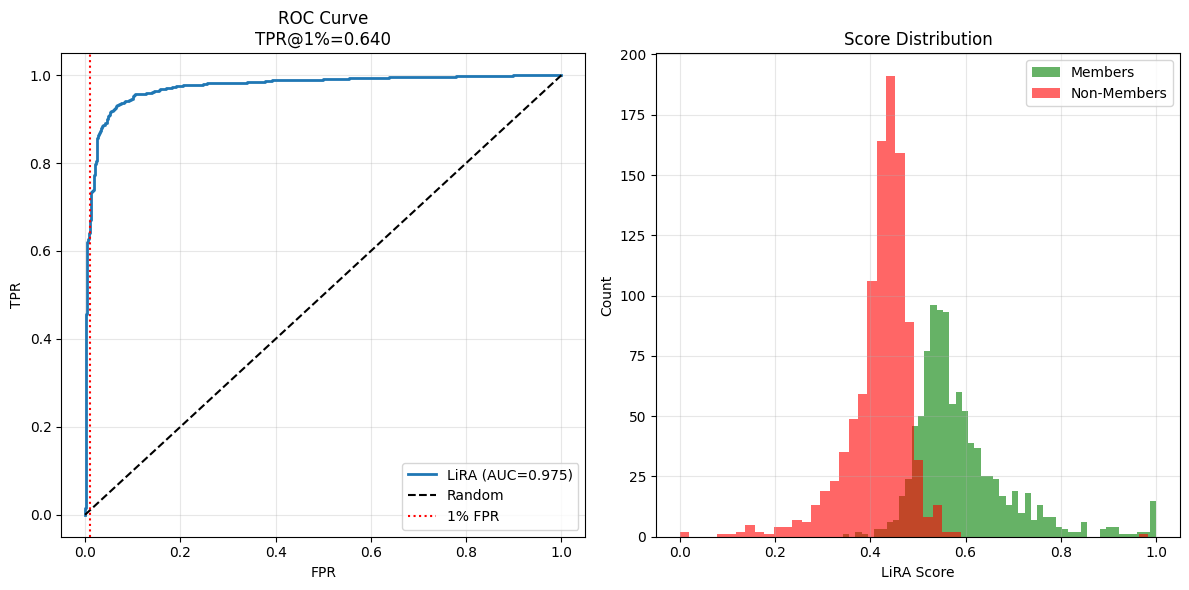

In [53]:
# Cell 11: Visualize

if has_labels:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Changed to 2 subplots
    
    # ROC Curve
    axes[0].plot(fpr, tpr, label=f'LiRA (AUC={auc:.3f})', linewidth=2)
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0].axvline(0.01, color='r', linestyle=':', label='1% FPR')
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_title(f'ROC Curve\nTPR@1%={tpr_at_1fpr:.3f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Score Distribution
    axes[1].hist(lira_scores_normalized[test_labels==1], bins=50, alpha=0.6, 
                 label='Members', color='green')
    axes[1].hist(lira_scores_normalized[test_labels==0], bins=50, alpha=0.6, 
                 label='Non-Members', color='red')
    axes[1].set_xlabel('LiRA Score')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Score Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    plt.hist(lira_scores_normalized, bins=50, alpha=0.7)
    plt.xlabel('LiRA Score')
    plt.ylabel('Count')
    plt.title('Score Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()

In [51]:
# Cell 12: Submission

def your_attack():
    """
    Per-example LiRA with 4 shadow models
    
    Returns:
        scores_test: numpy array (higher = more likely member)
    """
    return lira_scores_normalized

scores_test = your_attack()

print("="*70)
print("SUBMISSION")
print("="*70)
print(f"Phase: {phase}")
print(f"scores_test: {scores_test.shape}")
print(f"Range: [{scores_test.min():.4f}, {scores_test.max():.4f}]")
print(f"Mean: {scores_test.mean():.4f}")

if has_labels:
    verify_auc = roc_auc_score(test_labels, scores_test)
    fpr_v, tpr_v, _ = roc_curve(test_labels, scores_test)
    tpr_v = tpr_v[fpr_v < 0.01].max() if any(fpr_v < 0.01) else 0.0
    print(f"\nVerification:")
    print(f"  AUC: {verify_auc:.4f}")
    print(f"  TPR@1%: {tpr_v:.4f}")

print("\n✓ scores_test ready!")
print("="*70)

SUBMISSION
Phase: train
scores_test: (2000,)
Range: [0.0000, 1.0000]
Mean: 0.5060

Verification:
  AUC: 0.9748
  TPR@1%: 0.6400

✓ scores_test ready!


In [52]:
# Cell 13: Summary

print("="*70)
print("GAUSSIAN LIKELIHOOD RATIO LiRA SUMMARY")
print("="*70)
print(f"\n📊 Configuration:")
print(f"  Shadow models: {NUM_SHADOW_MODELS}")
print(f"  Test samples: {len(test_texts)}")
print(f"  Matrix M: {keep_matrix.shape}")
print(f"  Per-sample: 16 IN, 16 OUT shadows")

if has_labels:
    print(f"\n📈 Performance:")
    print(f"  AUC-ROC: {verify_auc:.4f}")
    print(f"  TPR @ 1% FPR: {tpr_v:.4f}")

print(f"\n🎯 Gaussian Likelihood Ratio LiRA:")
print(f"  ✓ Each sample: fit Gaussian to 16 IN losses, 16 OUT losses")
print(f"  ✓ Compare target loss to IN vs OUT distributions")
print(f"  ✓ Score = log P(target | IN) - log P(target | OUT)")
print(f"  ✓ Proper probabilistic interpretation")

print(f"\n📝 Key Fixes Applied:")
print(f"  ✓ Now uses target model's actual losses")
print(f"  ✓ Gaussian likelihood ratio (not simple mean diff)")
print(f"  ✓ Per-example calibration with 32 shadows")

print("\n" + "="*70)
print("✅ GAUSSIAN LIKELIHOOD RATIO LiRA COMPLETE")
print("="*70)

GAUSSIAN LIKELIHOOD RATIO LiRA SUMMARY

📊 Configuration:
  Shadow models: 32
  Test samples: 2000
  Matrix M: (2000, 32)
  Per-sample: 16 IN, 16 OUT shadows

📈 Performance:
  AUC-ROC: 0.9748
  TPR @ 1% FPR: 0.6400

🎯 Gaussian Likelihood Ratio LiRA:
  ✓ Each sample: fit Gaussian to 16 IN losses, 16 OUT losses
  ✓ Compare target loss to IN vs OUT distributions
  ✓ Score = log P(target | IN) - log P(target | OUT)
  ✓ Proper probabilistic interpretation

📝 Key Fixes Applied:
  ✓ Now uses target model's actual losses
  ✓ Gaussian likelihood ratio (not simple mean diff)
  ✓ Per-example calibration with 32 shadows

✅ GAUSSIAN LIKELIHOOD RATIO LiRA COMPLETE
